In [2]:
%matplotlib inline
import numpy 
from matplotlib import pyplot
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16
from matplotlib import animation
from JSAnimation.IPython_display import display_animation

In [7]:
from Traffic import rho_red_light, computeF

ImportError: No module named 'Traffic'

In [3]:
#Basic initial condition parameters
#defining grid size, time steps, CFL condition, etc...
nx = 101
nt = 30
dx = 4.0/(nx-2)

rho_in = 5.
rho_max = 10.

V_max = 1.

x = numpy.linspace(0,4,nx-1)


rho = rho_red_light(nx-1, rho_max, rho_in)

NameError: name 'rho_red_light' is not defined

In [8]:
def animate(data):
    x = numpy.linspace(0,4,nx-1)
    y = data
    line.set_data(x,y)
    return line,

In [9]:
def godunov(rho, nt, dt, dx, rho_max, V_max):
    """ Computes the solution with the Godunov scheme using the Lax-Friedrichs flux.
    
    Parameters
    ----------
    rho    : array of floats
            Density at current time-step
    nt     : int
            Number of time steps
    dt     : float
            Time-step size
    dx     : float
            Mesh spacing
    rho_max: float
            Maximum allowed car density
    V_max  : float
            Speed limit
    
    Returns
    -------
    rho_n : array of floats
            Density after nt time steps at every point x
    """
    
    #initialize our results array with dimensions nt by nx
    rho_n = numpy.zeros((nt,len(rho)))      
    #copy the initial u array into each row of our new array
    rho_n[:,:] = rho.copy()              
    
    #setup some temporary arrays
    rho_plus = numpy.zeros_like(rho)
    rho_minus = numpy.zeros_like(rho)
    flux = numpy.zeros_like(rho)
  
    for t in range(1,nt):
        
        rho_plus[:-1] = rho[1:] # Can't do i+1/2 indices, so cell boundary
        rho_minus = rho.copy() # arrays at index i are at location i+1/2
        flux = 0.5 * (computeF(V_max, rho_max, rho_minus) + 
                      computeF(V_max, rho_max, rho_plus) + 
                      dx / dt * (rho_minus - rho_plus))
        rho_n[t,1:-1] = rho[1:-1] + dt/dx*(flux[:-2]-flux[1:-1])
        rho_n[t,0] = rho[0]
        rho_n[t,-1] = rho[-1]
        rho = rho_n[t].copy()
        
    return rho_n

In [10]:
sigma = 1.0
dt = sigma*dx/V_max

rho = rho_red_light(nx-1, rho_max, rho_in)      #make sure that u is set to our expected initial conditions
rho_n = godunov(rho, nt, dt, dx, rho_max, V_max)

NameError: name 'rho_red_light' is not defined

NameError: name 'rho_n' is not defined

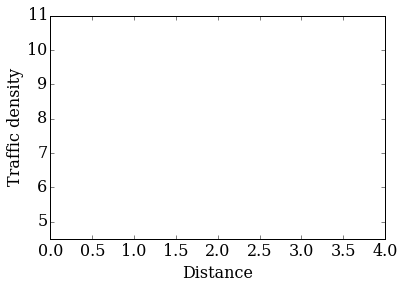

In [11]:
fig = pyplot.figure();
ax = pyplot.axes(xlim=(0,4),ylim=(4.5,11),xlabel=('Distance'),ylabel=('Traffic density'));
line, = ax.plot([],[],color='#003366', lw=2);

anim = animation.FuncAnimation(fig, animate, frames=rho_n, interval=50)
display_animation(anim, default_mode='once')

In [12]:
def minmod(e, dx):
    """
    Compute the minmod approximation to the slope
    
    Parameters
    ----------
    e : array of float 
        input data
    dx : float 
        spacestep
    
    Returns
    -------
    sigma : array of float 
            minmod slope
    """
    
    sigma = numpy.zeros_like(e)
    de_minus = numpy.ones_like(e)
    de_plus = numpy.ones_like(e)
    
    de_minus[1:] = (e[1:] - e[:-1])/dx
    de_plus[:-1] = (e[1:] - e[:-1])/dx
    
    # The following is inefficient but easy to read
    for i in range(1, len(e)-1):
        if (de_minus[i] * de_plus[i] < 0.0):
            sigma[i] = 0.0
        elif (numpy.abs(de_minus[i]) < numpy.abs(de_plus[i])):
            sigma[i] = de_minus[i]
        else:
            sigma[i] = de_plus[i]
            
    return sigma

In [13]:
def muscl(rho, nt, dt, dx, rho_max, V_max):
    """ Computes the solution with the MUSCL scheme using the Lax-Friedrichs flux,
    RK2 in time and minmod slope limiting.
    
    Parameters
    ----------
    rho    : array of floats
            Density at current time-step
    nt     : int
            Number of time steps
    dt     : float
            Time-step size
    dx     : float
            Mesh spacing
    rho_max: float
            Maximum allowed car density
    V_max  : float
            Speed limit
    
    Returns
    -------
    rho_n : array of floats
            Density after nt time steps at every point x
    """
    
    #initialize our results array with dimensions nt by nx
    rho_n = numpy.zeros((nt,len(rho)))      
    #copy the initial u array into each row of our new array
    rho_n[:,:] = rho.copy()              
    
    #setup some temporary arrays
    rho_plus = numpy.zeros_like(rho)
    rho_minus = numpy.zeros_like(rho)
    flux = numpy.zeros_like(rho)
    rho_star = numpy.zeros_like(rho)

    for t in range(1,nt):
               
        sigma = minmod(rho,dx) #calculate minmod slope

        #reconstruct values at cell boundaries
        rho_left = rho + sigma*dx/2.
        rho_right = rho - sigma*dx/2.     
        
        flux_left = computeF(V_max, rho_max, rho_left) 
        flux_right = computeF(V_max, rho_max, rho_right)
        
        #flux i = i + 1/2
        flux[:-1] = 0.5 * (flux_right[1:] + flux_left[:-1] - dx/dt *\
                          (rho_right[1:] - rho_left[:-1] ))
        
        #rk2 step 1
        rho_star[1:-1] = rho[1:-1] + dt/dx * (flux[:-2] - flux[1:-1])
        
        rho_star[0] = rho[0]
        rho_star[-1] = rho[-1]
        
        
        sigma = minmod(rho_star,dx) #calculate minmod slope
    
        #reconstruct values at cell boundaries
        rho_left = rho_star + sigma*dx/2.
        rho_right = rho_star - sigma*dx/2.
        
        flux_left = computeF(V_max, rho_max, rho_left) 
        flux_right = computeF(V_max, rho_max, rho_right)
        
        flux[:-1] = 0.5 * (flux_right[1:] + flux_left[:-1] - dx/dt *\
                          (rho_right[1:] - rho_left[:-1] ))
        
        rho_n[t,1:-1] = .5 * (rho[1:-1] + rho_star[1:-1] + dt/dx * (flux[:-2] - flux[1:-1]))
        
        rho_n[t,0] = rho[0]
        rho_n[t,-1] = rho[-1]
        rho = rho_n[t].copy()
        
    return rho_n

In [14]:
sigma = 1.
dt = sigma*dx/V_max
rho = rho_red_light(nx-1, rho_max, rho_in)      #make sure that u is set to our expected initial conditions
rho_n = muscl(rho, nt, dt, dx, rho_max, V_max)

NameError: name 'rho_red_light' is not defined

NameError: name 'rho_n' is not defined

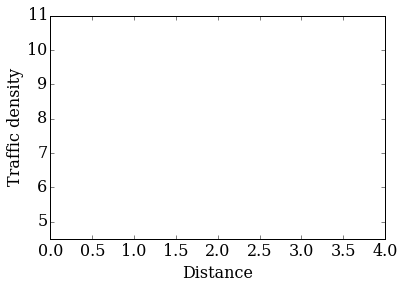

In [15]:
fig = pyplot.figure();
ax = pyplot.axes(xlim=(0,4),ylim=(4.5,11),xlabel=('Distance'),ylabel=('Traffic density'));
line, = ax.plot([],[],color='#003366', lw=2);

anim = animation.FuncAnimation(fig, animate, frames=rho_n, interval=50)
display_animation(anim, default_mode='once')